<a href="https://colab.research.google.com/github/Elmir22/Data-science-ML-models-/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


In [2]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [3]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [4]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

In [5]:
text_vec_layer.get_vocabulary()

['',
 '[UNK]',
 ' ',
 'e',
 't',
 'o',
 'a',
 'i',
 'h',
 's',
 'r',
 'n',
 '\n',
 'l',
 'd',
 'u',
 'm',
 'y',
 'w',
 ',',
 'c',
 'f',
 'g',
 'b',
 'p',
 ':',
 'k',
 'v',
 '.',
 "'",
 ';',
 '?',
 '!',
 '-',
 'j',
 'q',
 'x',
 'z',
 '3',
 '&',
 '$']

In [6]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  #

In [7]:
n_tokens

39

In [8]:
dataset_size

1115394

In [9]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [10]:
# sequence = [0, 1, 2, 3, 4, 5]

# windows: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5]]

# input-target pairs: [([0, 1, 2], [1, 2, 3]), ([1, 2, 3], [2, 3, 4]), ([2, 3, 4], [3, 4, 5])]

# [[[1, 2, 3], [2, 3, 4]], [[3, 4, 5]]] (inputs)
# [[[2, 3, 4], [3, 4, 5]], [[4, 5, 6]]] (targets)


In [11]:
list(to_dataset(tf.range(10), 3))

[(<tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8],
         [7, 8, 9]], dtype=int32)>)]

In [12]:
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [13]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

# Building and Training the Char-RNN Mode

In [14]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=3,
                    callbacks=[model_ckpt])

Epoch 1/3
31247/31247 [==============================] - 517s 15ms/step - loss: 1.4115 - accuracy: 0.5686 - val_loss: 1.6387 - val_accuracy: 0.5257
Epoch 2/3
31247/31247 [==============================] - 447s 14ms/step - loss: 1.3139 - accuracy: 0.5915 - val_loss: 1.6125 - val_accuracy: 0.5321
Epoch 3/3
31247/31247 [==============================] - 517s 16ms/step - loss: 1.2950 - accuracy: 0.5954 - val_loss: 1.5960 - val_accuracy: 0.5355


In [15]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

In [16]:
# extra code – downloads a pretrained model
from pathlib import Path
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = tf.keras.models.load_model(model_path)

352865/352865 [==============================] - 0s 0us/step


In [17]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 413ms/step


'e'

# Generating Fake Shakespearean Text

In [18]:

log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]])>

In [19]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [20]:
def extend_text(text, n_chars=100, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [21]:
tf.random.set_seed(42)

In [22]:
print(extend_text('''Now we are even''', temperature=0.01))

1/1 [==============================] - 0s 32ms/step
Now we are even to the death,
and then the sea to the death, and the duke and the death,
and then the strange daugh


In [23]:
print(extend_text("now we are even", temperature=1))

1/1 [==============================] - 0s 33ms/step
now we are even.

dorcas:
what ignora from his grief:
truly--a praise and men take him of assistion do thee?

hermi


In [24]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 32ms/step
To be or not to betas'xosq;!jorar:p?i.ies;astsz-;jbrpi!deqs?cp;??
:sbkjd3c$;mqm?hebxzwc33efy,bopkyi3,r'g,m:,:qn-grns;w


# Stateful RNN

In [25]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [26]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

In [27]:
# extra code – shows one way to prepare a batched dataset for a stateful RNN

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

In [28]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [29]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

In [30]:
# Warning: the following cell will take a while to run (possibly an hour if you are not using a GPU).
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=7, callbacks=[ResetStatesCallback(), model_ckpt])

Epoch 1/7
9999/9999 [==============================] - 93s 9ms/step - loss: 1.4873 - accuracy: 0.5446 - val_loss: 1.6190 - val_accuracy: 0.5187
Epoch 2/7
9999/9999 [==============================] - 86s 9ms/step - loss: 1.4556 - accuracy: 0.5509 - val_loss: 1.6047 - val_accuracy: 0.5241
Epoch 3/7
9999/9999 [==============================] - 90s 9ms/step - loss: 1.4422 - accuracy: 0.5540 - val_loss: 1.5979 - val_accuracy: 0.5210
Epoch 4/7
9999/9999 [==============================] - 95s 10ms/step - loss: 1.4332 - accuracy: 0.5564 - val_loss: 1.5840 - val_accuracy: 0.5251
Epoch 5/7
9999/9999 [==============================] - 97s 10ms/step - loss: 1.4266 - accuracy: 0.5584 - val_loss: 1.5872 - val_accuracy: 0.5237
Epoch 6/7
9999/9999 [==============================] - 93s 9ms/step - loss: 1.4226 - accuracy: 0.5597 - val_loss: 1.5870 - val_accuracy: 0.5208
Epoch 7/7
9999/9999 [==============================] - 88s 9ms/step - loss: 1.4199 - accuracy: 0.5603 - val_loss: 1.5737 - val_accurac

In [31]:
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [32]:

stateless_model.build(tf.TensorShape([None, None]))

In [33]:
stateless_model.set_weights(model.get_weights())

In [34]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    stateless_model
])

In [35]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=0.01))

1/1 [==============================] - 0s 143ms/step
to be or not to be a sounds and heard
and heard her be a gentleman in the world heard to her and heard
and heard her b


# Sentiment Analysis

In [36]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RZ33Z0_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RZ33Z0_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.RZ33Z0_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [37]:
for review, label in raw_train_set.take(4):
    print(review.numpy()[:200], "...")
    print("Label:", label.numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting " ...
Label: 0
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ' ...
Label: 0
b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun' ...
Label: 0
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf' ...
Label: 1


In [38]:

vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [39]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 1170s 2s/step - loss: 0.6934 - accuracy: 0.5013 - val_loss: 0.6930 - val_accuracy: 0.5024
Epoch 2/2
704/704 [==============================] - 1100s 2s/step - loss: 0.6934 - accuracy: 0.5039 - val_loss: 0.7143 - val_accuracy: 0.4992


# Masking

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 1480s 2s/step - loss: 0.5164 - accuracy: 0.7336 - val_loss: 0.6718 - val_accuracy: 0.7296
Epoch 2/5
114/704 [===>..........................] - ETA: 23:11 - loss: 0.3800 - accuracy: 0.8418

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
# extra code – compiles and trains the model, as usual
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

In [ ]:

text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, ragged=True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

In [ ]:

text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer_ragged,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

# Reusing Pretrained Embeddings and Language Models

In [ ]:
import os
import tensorflow_hub as hub

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=True, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=10)

# An Encoder–Decoder Network for Neural Machine Translation

In [ ]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

In [ ]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [ ]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

In [ ]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [ ]:
text_vec_layer_en.get_vocabulary()[:10]

In [ ]:
text_vec_layer_es.get_vocabulary()[:10]

In [ ]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [ ]:

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [ ]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [ ]:
translate("I like soccer")

In [ ]:
translate("I like soccer and also going to the beach")

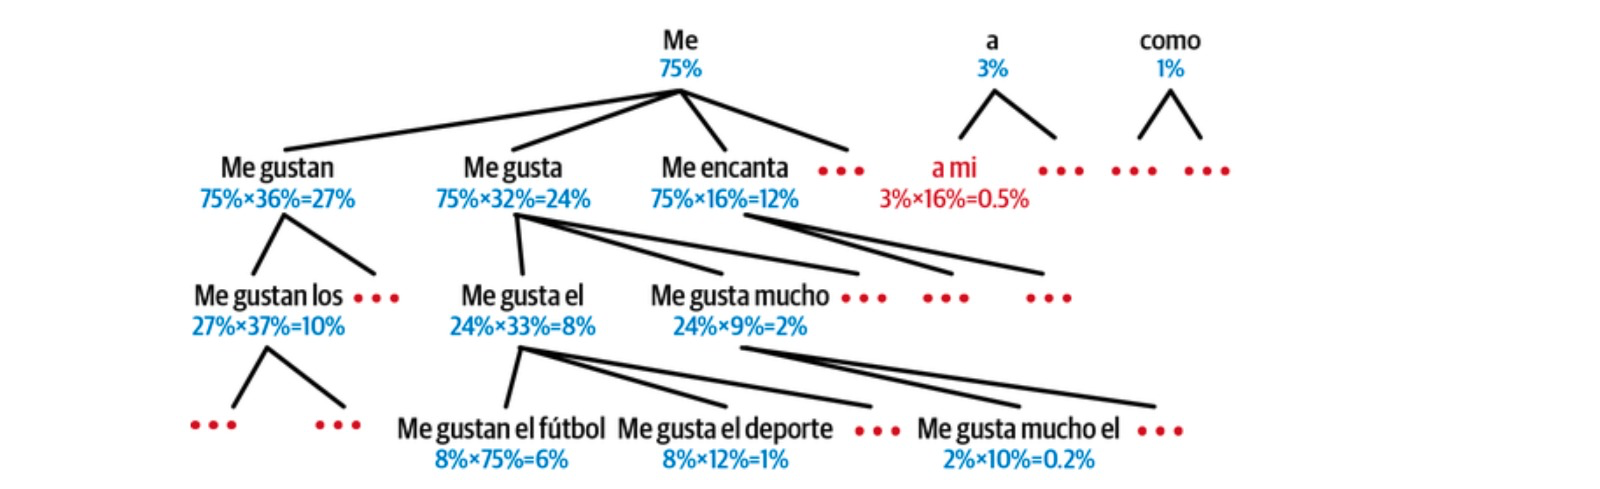

# Bidirectional RNNs

In [ ]:

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [ ]:
# extra code — completes the model and trains it
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

In [ ]:
translate("I like soccer")

# Beam Search

In [ ]:
def beam_search(sentence_en, beam_width, verbose=False):
  X = np.array([sentence_en])
  X_dec = np.array(["startofseq"])
  Y_proba = model.predict((X, X_dec))[0, 0]
  top_k = tf.math.top_k(Y_proba, k=beam_width)
  top_translations = [# list of best(log_proba, translation)
      (np.log(word_prooba), text_vec_layer_es.get_vocabulary()[word_id])
      for word_prooba, word_id in zip(top_k.values, top_k.indices)]

  #extra code - displays the top first words in verbose mode
  if verbose:
    print("Top first words:", top_translations)

  for idx in range(1, max_length):
    candidates = []
    for log_proba, translation in top_translations:
      if translation.endswith("endofseq"):
        candidates.append((log_proba, translation))
        continue # translation is finished, so don't try to extend it
      X = np.array([sentence_en]) #encoder input
      X_dec = np.array(["startofseq "+ translation]) #decoder input
      y_proba = model.predict((X, X_dec))[0, idx] #last token's proba
      for word_id, word_proba in enumerate(y_proba):
        word = text_vec_layer_es.get_vocabulary()[word_id]
        candidates.append((log_proba + np.log(word_proba), f"{translation}{word}"))
    top_translations = sorted(candidates, reverse=True)[:beam_width]
    if verbose:
      print("Top translations so far:", top_translations)
    # extra code - displays the top translations so far in verbose mode
    if all([tr.endwith("endofseq") for _, tr in top_translations]):
      return top_translations[0][1].replace("endofseq", "").strip()

In [ ]:
sentence_en = "I love cats and dogs"
translate(sentence_en)

In [ ]:
beam_search(sentence_en, beam_width=3, verbose=True)

#Attention Mechanism

In [ ]:
tf.random.set_seed(42).  #extra code-ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))


In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
attention_layer = tf.keras.layers.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

In [ ]:
translate("I like soccer and also going to the beach")

In [ ]:
beam(" I like soccer and also going to the beach", beam_width=3, verbose=True)

#Attention Is ALL You Need: The Transformer Architecture

In [ ]:
max_length = 50 # max length in the whole traning set
embed_size = 128
tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length,embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [ ]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

In [ ]:
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

#Multi-Head Attention

In [ ]:
N =2
num_heads = 8
dropout_rate = 0.1
n_units = 128
encoder_pad_mask = tf.math.not_equal(encoder_inputs, 0)[:, tf.newaxis]
Z = encoder_in

for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_size,
                                                    dropout=dropout_rate)
  Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.Dropout(dropout_rate)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
decoder_pad_mask =tf.math.not_equal(encoder_inputs, 0)[:, tf.newaxis]
encoder_pad_mask = tf.math.not_equal(encoder_inputs, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(tf.ones((batch_max_len_dec, batch_max_len_dec),tf.bool),  -1, 0)

In [ ]:
encoder_outputs = Z
Z = decoder_in
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_size,
                                                    dropout=dropout_rate)
  Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                    key_dim=embed_size,
                                                    dropout=dropout_rate)
  Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))


In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

#HugGing FACE

In [ ]:
if "google.colab" in sys.modules:
  %pip install -q -U transformers
  %pip install -q -U sentencepiece

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
result = classifier("the actors were very convincing")

In [ ]:
classifier(["I am from india.", "I am from iraq."])

In [ ]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline('text-classification', model=model_name)
classifier_mnli("she loves me. [SEP] she loves me too")

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
token_ids = tokenizer(" I like soccer. [SEP] we all love soccer!",
                      "joe lived in new york",
                      padding=